### Tomography reconstruction

$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to solve  $Ax = b$,
where $A$ is a matrix, obtained from the projection tomography operator and $b$ is the observed sinogram.

In [1]:
import scipy.sparse.linalg as spr_LA
import matplotlib as mpl
from skimage import data, transform, img_as_float, transform
from skimage.color import rgb2gray
from tomo_utils import generate_synthetic_data, build_projection_operator
from fixed_points import *
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate the data

In [2]:
# number of positions
n_pos = 256
# number or angles
n_angles = 128
#img = generate_synthetic_data(p)

x = rgb2gray(data.load('phantom.png'))
img = transform.resize(x, (n_pos, n_pos))

w = img.ravel()
A = build_projection_operator(n_pos, n_angles)
#A = build_projection_operator(n_pos, n_dir=n_angles, l_det=64)


n = n_pos * n_pos
m = n_pos * n_angles

x_true = w

# no noise
#b = A.dot(x_true)

# with noise
b = A.dot(x_true) + np.random.randn(m)

# starting point
x0 = np.zeros(n)

# define operator T:
norms = spr_LA.norm(A, axis=1)
T = lambda x: x - 1./m * A.T.dot((A.dot(x)-b)/norms**2)

J = lambda x: LA.norm(T(x)-x)



/nix/store/8qv2qbscqh6z90vz7b5839s2zygiam7r-python3-3.6.8-env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/nix/store/8qv2qbscqh6z90vz7b5839s2zygiam7r-python3-3.6.8-env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
N = 1000

ans1 = krasn_mann(T, x0, 0, numb_iter=N)
ans2 = fixed_point_agraal(T, x0, numb_iter=N, phi=1.5, output=False)

x1 = ans1[1]
x2 = ans2[1]    

Time execution of K-M: 157.148232824984
1
Time execution of aGRAAL: 159.4507064089994


In [4]:
print("Fixed point residuals. KM and aGRAAL:", J(x1), J(x2))

Fixed point residuals. KM and aGRAAL: 0.01206923787295626 4.7282722448181315e-05


Show the results

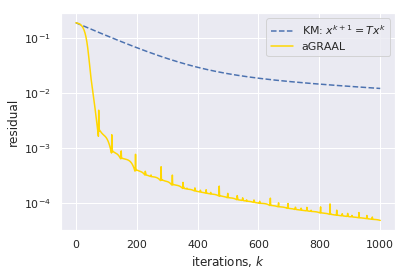

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(ans1[0], '--b', label="KM: $x^{k+1}=Tx^k$")

plt.plot(ans2[0], '#FFD700', label="aGRAAL")

plt.yscale('log')
plt.legend()


plt.xlabel(u'iterations, $k$')
plt.ylabel('residual')

plt.legend()
#plt.grid()
plt.savefig('figures/tomo-12-darkgrid.pdf',bbox_inches='tight')
plt.show()
plt.clf()

What is the stepsize in aGRAAL?

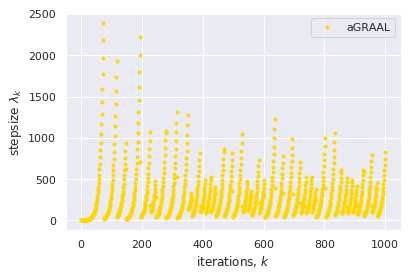

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(ans2[2], '.', color='#FFD700', label="aGRAAL")
plt.legend()


plt.xlabel(u'iterations, $k$')
plt.ylabel('stepsize $\lambda_k$')

plt.legend()
#plt.grid()
plt.savefig('figures/tomo-22-darkdrid.pdf',bbox_inches='tight')
plt.show()
plt.clf()

Show the original image and reconstructed ones

Original image and reconstructed ones


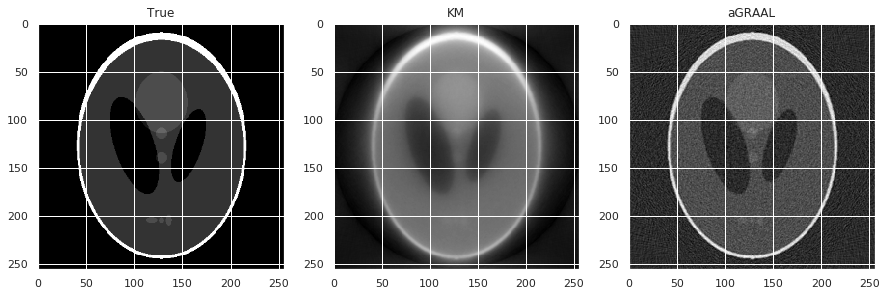

In [8]:
print("Original image and reconstructed ones")
img1 = x1.reshape(n_pos, n_pos)
img2 = x2.reshape(n_pos, n_pos)
fig, ax, = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("True")
ax[1].imshow(img1, cmap='gray')
ax[1].set_title("KM")
ax[2].imshow(img2, cmap='gray')
ax[2].set_title("aGRAAL")
plt.show(fig)


Clearly, all reconstructed images are not very good, but still aGRAAL is much better. Moral: do not reconstuct without regularization.